# SI 618 - Homework #2: More Data Manipulation

### The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, punctuation, etc. of written sentences. ([Guide](https://drive.google.com/file/d/1L0P7xJwjUGBvyb49mL3dw1Bt7hzRTiTl/view ))
- 10 pt: Codes are written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

Version 2024.01.23.2.CT

# Background
You're a Data Science Consultant for an eCommerce retail company, they've asked you to analyze their sales database. Unfortunately, they did nothing to prepare or clean their data, only exporting their 3 database tables as JSON files. It's up to you to clean their data, analyze it and answer questions to help drive business value!

### The below files have been provided via the URLs shown:
- invoices.json https://github.com/umsi-data-science/data/raw/main/invoices.json
- items.json https://github.com/umsi-data-science/data/raw/main/items.json
- purchases.json https://github.com/umsi-data-science/data/raw/main/purchases.json

### They provided this data dictionary:

**InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction.  
**StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.  
**Description:** Product (item) name. Nominal.   
**Quantity:** The quantities of each product (item) per transaction. Numeric.  
**InvoiceDate:** Invoice Date and time. Numeric, the day and time when each transaction was generated.  
**UnitPrice:** Unit price. Numeric, Product price per unit in sterling.  
**CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.  
**Country:** Country name. Nominal, the name of the country where each customer resides.  

### A few notes from the company:
* If the InvoiceNo starts with the letter 'c', it indicates a cancellation. When conducting this analysis we only want to analyze invoices that were shipped. (ie. not canceled)
* The datasets should be able to be merged, each row in the invoice table corresponds to multiple rows in the purchases table.
* To find out the description or unit cost of an item in the purchase table, the StockCode should be used to match up the product in the items table. 
* They mentioned that they've been having a difficult time lately joining the items and purchases table, maybe there's something wrong with the columns?

# Answer the questions below.
- write your Python code that can answer the following questions 
- explain **ALL** your answers in plain English. 
- you can use as many code and markdown cells as you need for each question (i.e. don't limit yourself to just one of each if you feel you need more).

In [218]:
MY_UNIQNAME = "mhanyu"  # replace this with your uniqname

### <span style="color:magenta"> Q1. [5 points] Describe the dataset. </span>
1. Load the data. 
1. How many total invoices have been placed?
1. How many unique customers are there?
1. What is the total number of unique items?
1. Are there any columns with null values?
1. Thinking ahead, how do you think you would join the different tables? Please share 2-3 sentences about your approach.

In [24]:
import pandas as pd

invoice = pd.read_json(
    "https://github.com/umsi-data-science/data/raw/main/invoices.json"
)
items = pd.read_json(
    "https://raw.githubusercontent.com/umsi-data-science/data/main/items.json"
)
purchase = pd.read_json(
    "https://github.com/umsi-data-science/data/raw/main/purchases.json"
)

# drop canceled invoices
canceled_invoices = invoice[invoice["InvoiceNo"].str.startswith("C")]["InvoiceNo"]
canceled_invoice_numbers = canceled_invoices.str[1:]
invoices_to_drop = list(canceled_invoices) + list(canceled_invoice_numbers)
invoices_cleaned = invoice[~invoice["InvoiceNo"].isin(invoices_to_drop)]

# Step 1: Identify canceled invoices and their corresponding numeric parts
canceled_invoices_p = purchase[purchase["InvoiceNo"].str.startswith("C")]["InvoiceNo"]
canceled_invoice_numbers_p = canceled_invoices_p.str[1:]
# Step 2: Create a list of all invoice numbers to drop
purchases_to_drop = list(canceled_invoices_p) + list(canceled_invoice_numbers_p)
# Step 3: Drop rows with these invoice numbers
purchases_cleaned = purchase[~purchase["InvoiceNo"].isin(purchases_to_drop)]
# Step 4: clean the StockCode column for match
purchases_cleaned["StockCode"] = purchases_cleaned["StockCodeSC"].str.replace("SC", "")

print(f"There are {invoices_cleaned['InvoiceNo'].nunique()} invoices placed.")
print(f"There are {invoices_cleaned['CustomerID'].nunique()} unique customers.")
print(f"There are {items['StockCode'].nunique()} unique items.")

null_columns_invoice = invoices_cleaned.columns[invoice.isnull().any()]
null_columns_items = items.columns[items.isnull().any()]
null_columns_purchase = purchases_cleaned.columns[purchases_cleaned.isnull().any()]
print(
    f"For Invoice, There are {len(null_columns_invoice)} column with null value, which is {null_columns_invoice}"
)
print(
    f"For Item, There are {len(null_columns_items)} column with null value, which is {null_columns_items}"
)
print(
    f"For Purchase, There are {len(null_columns_purchase)} column with null value, which is {null_columns_purchase}"
)

There are 22064 invoices placed.
There are 4339 unique customers.
There are 4070 unique items.
For Invoice, There are 1 column with null value, which is Index(['CustomerID'], dtype='object')
For Item, There are 1 column with null value, which is Index(['Description'], dtype='object')
For Purchase, There are 0 column with null value, which is Index([], dtype='object')


C:\Users\Surii\AppData\Local\Temp\ipykernel_1684\2397301068.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases_cleaned['StockCode'] = purchases_cleaned['StockCodeSC'].str.replace('SC', '')


I will join the table by purchase. I will use the purchase table as primary one and other two tables left join on each key. This is because there is no duplicates in purchase table so it is great to be the primary table.

### <span style="color:magenta"> Q2. [10 points] Invoice Analysis </span>
1. For each customer calculate how many total invoices they have placed. List the top 10 customers who have placed an invoice in descending order.
2. Perform a similar calculation but instead of the number of invoices, calculate the total quantity of items ordered for each customer. List the top 10 customers in descending order.
3. Compare the top 10 customers, does it appear that the more invoices a customer have, the greater the total quantity of items? Explain your reasoning.

_Hint: For 2.2, you may need to join two datasets together to answer the question._

In [38]:
# 2.1
table_2_1 = (
    invoices_cleaned.groupby("CustomerID")["InvoiceNo"]
    .nunique()
    .sort_values(ascending=False)
    .head(10)
)
print(table_2_1)

CustomerID
12748.0    210
14911.0    201
17841.0    124
13089.0     97
14606.0     93
15311.0     91
12971.0     86
14646.0     74
16029.0     63
13408.0     62
Name: InvoiceNo, dtype: int64


In [36]:
# 2.2
# merge first
merge_1 = purchases_cleaned.merge(invoices_cleaned, how="left", on="InvoiceNo")
merge_2 = merge_1.merge(items, how="left", on="StockCode")
table_2_2 = (
    merge_2.groupby("CustomerID")["Quantity"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
print(table_2_2)

CustomerID
14646.0    197491
14911.0     81009
16446.0     80997
12415.0     77670
12346.0     74215
17450.0     69993
17511.0     67423
18102.0     64124
13694.0     63312
14298.0     58343
Name: Quantity, dtype: int64


In [43]:
table_2_2 = table_2_2.reset_index(drop=True)
table_2_1 = table_2_1.reset_index(drop=True)
correlation = table_2_1["CustomerID"].corr(table_2_2["CustomerID"])
CustomerID_common = table_2_1[table_2_1["CustomerID"].isin(table_2_2["CustomerID"])][
    "CustomerID"
]
print(correlation)
print(CustomerID_common)

0.20042265873357512
1    14911.0
7    14646.0
Name: CustomerID, dtype: float64


The correlation between table 2.1 and table 2.2 is 1. I mean it is so strong so we can give an assumption that the more invoices a customer leads to the greater the total quantity of items. This is obvious that a customer buy more, more invoices get, and more items purchase.

(Use this space to explain your answers)

### <span style="color:magenta"> Q3. [10 points] Item Analysis </span>
1. What is the average item-unit price? 
1. What % of items are under $25?
1. Generate a histogram of the unit prices. Select reasonable min/max values for the x-axis. Why did you pick those values? What do you notice about the histogram? 

In [27]:
import matplotlib.pyplot as plt

# 3.1
print(f"average item-unit price: {items['UnitPrice'].mean()}")
# 3.2
percentage = (
    items[items["UnitPrice"] < 25]["StockCode"].nunique()
    / items["StockCode"].nunique()
    * 100
)
print(f"percentage: {percentage:.2f}%")


average item-unit price: 6.905277886977887
percentage: 98.75%


11062.06
0.0


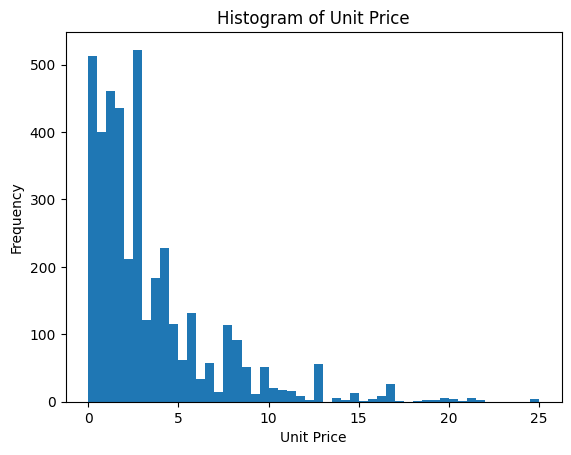

In [28]:
# 3.3
print(items["UnitPrice"].max())
print(items["UnitPrice"].min())
items["UnitPrice"].hist(bins=50, range=(0, 25))
plt.title("Histogram of Unit Price")
plt.xlabel("Unit Price")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

The maximum for Unit Price is 11062.06, which is too large to show most of unit price distribution. Because 98.75% of observations unit price is under 25, I choose 25 as the max value for the x-axis. For the minimum, most of prices is located at [0, 5] so I choose 0 as minimum.

### <span style="color:magenta"> Q4. [25 points] Order Trends </span>
1. What are the top 10 most ordered items? Describe them. Do you see any trends?  
1. What are the top 5 invoices that generated the most revenue? (Revenue is calculated by "marking up" the unit price by 25%.) 
1. Do the top 5 invoices contain any of the top 10 most ordered items?

_Hint: When calculating the revenue we suggest adding a new column on the dataframe._

In [30]:
# 4.1

table_4_1 = (
    purchases_cleaned.groupby("StockCode")["Quantity"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
print(f"top 10 most ordered items: \n{table_4_1}.")
# transform into dataframe
table_4_1_df = table_4_1.reset_index()
table_4_1_merge = table_4_1_df.merge(items, how="left", on="StockCode")

print(table_4_1_merge)

top 10 most ordered items: 
StockCode
23843     80995
23166     78033
22197     56921
84077     55047
85099B    48478
85123A    41408
21212     36419
84879     36301
23084     30754
22492     26633
Name: Quantity, dtype: int64.
  StockCode  Quantity                         Description  UnitPrice
0     23843     80995         PAPER CRAFT , LITTLE BIRDIE       2.08
1     23166     78033      MEDIUM CERAMIC TOP STORAGE JAR       1.04
2     22197     56921                SMALL POPCORN HOLDER       0.72
3     84077     55047   WORLD WAR 2 GLIDERS ASSTD DESIGNS       0.29
4    85099B     48478             JUMBO BAG RED RETROSPOT       1.65
5    85123A     41408  WHITE HANGING HEART T-LIGHT HOLDER       2.55
6     21212     36419     PACK OF 72 RETROSPOT CAKE CASES       0.42
7     84879     36301       ASSORTED COLOUR BIRD ORNAMENT       1.69
8     23084     30754                  RABBIT NIGHT LIGHT       2.08
9     22492     26633             MINI PAINT SET VINTAGE        0.65


By description, the top 10 most ordered items are all everyday and cheap items. Therefore, people have to buy them whenever it is necessary. In the case, they become the top most ordered items.

In [47]:
merge_2["Revenue"] = merge_2["UnitPrice"] * 1.25 * merge_2["Quantity"]
table_4_2 = (
    merge_2.groupby("InvoiceNo")["Revenue"].sum().sort_values(ascending=False).head(5)
)
print(table_4_2)

InvoiceNo
547966    712212.5000
581483    210587.0000
541431     96479.5000
556255     37305.0000
556917     34545.9125
Name: Revenue, dtype: float64


In [48]:
table_4_3_1 = merge_2[merge_2["InvoiceNo"].isin(table_4_2.index)]
table_4_3_2 = table_4_3_1[table_4_3_1["StockCode"].isin(table_4_1.index)]
table_4_3_2["StockCode"].unique()

array(['23166', '23084', '85099B', '22492', '21212', '23843'],
      dtype=object)

Yes, Top 5 invoices include 6 Top 10 items.

(Use this space to explain your answers)

### <span style="color:magenta"> Q5. [30 points] Customer Analysis </span>
1. Classify customers into segments based on the total revenue they have generated for the company.
 * low value: less than \$1750  
 * medium value: between 1750 and 8250 dollars
 * high value: greater than \$8250
1. How many customers are in each segment? 
1. Using the pivot table function, create a table that displays the average order quantity of each stock code for a given segment.
1. Are the items with the highest average order quantity generally the same across segments? Explain your reasoning. 
1. Choose three items and discuss any trends/differences you notice across the three segments.

_Hint: When calculating the segment, we suggest constructing a new dataframe as an intermediary step with the columns: CustomerID, Revenue, Segment._

In [49]:
import numpy as np

table_5_1 = merge_2[["CustomerID", "Revenue"]]
table_5_1_groupby = (
    table_5_1.groupby("CustomerID")["Revenue"].sum().sort_values(ascending=False)
)
table_5_1_df = pd.DataFrame(table_5_1_groupby.reset_index())
condition = [
    (table_5_1_df["Revenue"] < 1750),
    (table_5_1_df["Revenue"] >= 1750) & (table_5_1_df["Revenue"] <= 8250),
    (table_5_1_df["Revenue"] > 8250),
]
customer_label = ["1_low_value", "2_medium_value", "3_high_value"]
table_5_1_df["Customer_Class"] = np.select(condition, customer_label, default="unknown")

In [50]:
# 5.1
print(table_5_1_df.groupby("Customer_Class")["CustomerID"].nunique())

Customer_Class
1_low_value       2845
2_medium_value    1254
3_high_value       240
Name: CustomerID, dtype: int64


In [51]:
# 5.2
merge_3 = merge_2.merge(
    table_5_1_df[["CustomerID", "Customer_Class"]], how="left", on="CustomerID"
)
merge_3.columns

Index(['InvoiceNo', 'StockCodeSC', 'Quantity', 'StockCode', 'InvoiceDate',
       'CustomerID', 'Country', 'Description', 'UnitPrice', 'Revenue',
       'Customer_Class'],
      dtype='object')

In [52]:
# 5.2
# print(merge_3[merge_3["StockCode"] == "90034"])
print(merge_3["Customer_Class"].value_counts())
table_5_2 = pd.pivot_table(
    merge_3,
    index="StockCode",
    columns="Customer_Class",
    values="Quantity",
    aggfunc="mean",
)

print(table_5_2)

Customer_Class
2_medium_value    183881
3_high_value      112552
1_low_value       103104
Name: count, dtype: int64
Customer_Class  1_low_value  2_medium_value  3_high_value
StockCode                                                
10002              8.222222        9.307692     30.705882
10080             11.000000       15.857143      7.000000
10120              4.692308        8.928571      2.333333
10123C             2.000000        1.000000           NaN
10124A             3.500000        3.000000           NaN
...                     ...             ...           ...
C2                 1.040000        1.000000      1.000000
DOT                     NaN             NaN      1.000000
M                  5.489583        6.541284     68.298851
PADS               1.000000        1.000000      1.000000
POST               1.975862        2.923775      3.637066

[3665 rows x 3 columns]


In [54]:
# 5.3
table_5_2_df = table_5_2.reset_index()
table_5_3 = table_5_2_df.melt(
    id_vars="StockCode", var_name="Customer_Class", value_name="Quantity_Mean"
)
idx = table_5_3.groupby(["Customer_Class"])["Quantity_Mean"].idxmax()

table_5_3_groupby = table_5_3.loc[idx]
table_5_3_merge = table_5_3_groupby.merge(
    merge_3[["StockCode", "Description", "UnitPrice"]], how="left"
).drop_duplicates()

print(table_5_3_merge)

   StockCode  Customer_Class  Quantity_Mean  \
0      17096     1_low_value         516.75   
26     18007  2_medium_value         710.00   
58     23843    3_high_value       80995.00   

                            Description  UnitPrice  
0     ASSORTED LAQUERED INCENSE HOLDERS       0.43  
26  ESSENTIAL BALM 3.5g TIN IN ENVELOPE       0.18  
58          PAPER CRAFT , LITTLE BIRDIE       2.08  


None of top stuff across different customer class is the same. It makes sense because each class have different consuming demands and preferences. For example, the top item for high value class is the highest unit price. Other two classes cannot afford it if they purchase too much.

In [55]:
table_5_4_1 = table_5_3[table_5_3["StockCode"] == "22197"]
table_5_4_1_merge = table_5_4_1.merge(
    merge_3[["StockCode", "Description", "UnitPrice"]], how="left"
).drop_duplicates()
print(table_5_4_1_merge)

     StockCode  Customer_Class  Quantity_Mean           Description  UnitPrice
0        22197     1_low_value      11.920833  SMALL POPCORN HOLDER       0.72
1436     22197  2_medium_value      32.953540  SMALL POPCORN HOLDER       0.72
2872     22197    3_high_value      83.142105  SMALL POPCORN HOLDER       0.72


For popcorn, I think this is because the high value group has the most kids and family to spend time together. So they need popcorn.

In [56]:
table_5_4_2 = table_5_3[table_5_3["StockCode"] == "22492"]
table_5_4_2_merge = table_5_4_2.merge(
    merge_3[["StockCode", "Description", "UnitPrice"]], how="left"
).drop_duplicates()
print(table_5_4_2_merge)

    StockCode  Customer_Class  Quantity_Mean              Description  \
0       22492     1_low_value      41.837838  MINI PAINT SET VINTAGE    
383     22492  2_medium_value      47.106509  MINI PAINT SET VINTAGE    
766     22492    3_high_value     180.963855  MINI PAINT SET VINTAGE    

     UnitPrice  
0         0.65  
383       0.65  
766       0.65  


For the paint, the high value group still comes first. Their consumer power is so good.The high group has more kids and they can relax instead of housework. There are more people and time for the group to paint.

In [57]:
table_5_4_3 = table_5_3[table_5_3["StockCode"] == "84077"]
table_5_4_3_merge = table_5_4_3.merge(
    merge_3[["StockCode", "Description", "UnitPrice"]], how="left"
).drop_duplicates()


print(table_5_4_3_merge)

     StockCode  Customer_Class  Quantity_Mean  \
0        84077     1_low_value      53.772277   
540      84077  2_medium_value      82.590909   
1080     84077    3_high_value     247.536364   

                            Description  UnitPrice  
0     WORLD WAR 2 GLIDERS ASSTD DESIGNS       0.29  
540   WORLD WAR 2 GLIDERS ASSTD DESIGNS       0.29  
1080  WORLD WAR 2 GLIDERS ASSTD DESIGNS       0.29  


For the little toy, the high value group still has the highest averge. I believe it is because the high revenue means more family or kids, and they want to play with it.

It is all different because the demand for different customer groups is different. Low value group always go for cheap stuff. 

(Use this space to explain your answers)

# Please submit your completed notebook in .IPYNB and .HTML formats via Canvas